In [10]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [11]:
sklearn.__version__

'1.0.2'

In [2]:
train = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Train_Dataset.csv")
test = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Test_Dataset.csv")
val = pd.read_csv("G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ECNG3020_Final_Dataset\ECNG3020_Val_Dataset.csv")

In [3]:
def get_text(data):
    text = data['text']
    labels = data['label']
    labels = labels.replace(["0","1","2","3","4","5"],['sadness','joy','love','anger','fear','surprise'])
    return text, labels

In [4]:
text, labels = get_text(train)

In [5]:
print(labels)

0            joy
1           fear
2          anger
3        sadness
4            joy
          ...   
19458    sadness
19459    sadness
19460        joy
19461      anger
19462    sadness
Name: label, Length: 19463, dtype: object


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(text)

In [8]:
tokenizer.texts_to_sequences([text[1]])

[[168, 45, 2, 946, 10, 136, 2, 89, 38, 2, 83, 1213, 7, 1241, 1145, 80, 344]]

In [9]:
text[1]

'Every time I imagine that someone I love or I could contact a serious illness, even death.'

<function matplotlib.pyplot.show(close=None, block=None)>

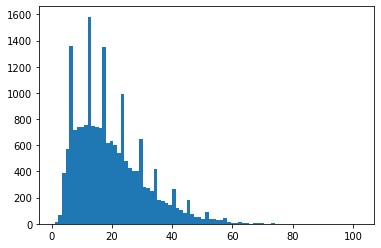

In [10]:
lengths = [len(t.split(' ')) for t in text]
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [11]:
maxlength = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
def get_sequences(tokenizer, text):
  sequences = tokenizer.texts_to_sequences(text)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlength)
  return padded

In [13]:
padded_train_seq = get_sequences(tokenizer, text)

In [14]:
padded_train_seq

array([[ 30, 157,  17, ...,   0,   0,   0],
       [168,  45,   2, ...,   0,   0,   0],
       [ 17,   2,  32, ...,   0,   0,   0],
       ...,
       [  2,   4, 370, ...,   0,   0,   0],
       [  2,   4,  18, ...,   0,   0,   0],
       [  2,  53,   7, ...,   0,   0,   0]])

In [15]:
#classes = set(labels)
classes = ['joy', 'fear', 'anger', 'sadness', 'love', 'surprise']
print(classes)

['joy', 'fear', 'anger', 'sadness', 'love', 'surprise']


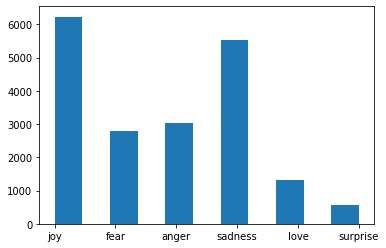

In [16]:
plt.hist(labels, bins=11)
plt.show()

In [17]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [18]:
class_to_index

{'joy': 0, 'fear': 1, 'anger': 2, 'sadness': 3, 'love': 4, 'surprise': 5}

In [19]:
index_to_class

{0: 'joy', 1: 'fear', 2: 'anger', 3: 'sadness', 4: 'love', 5: 'surprise'}

In [20]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [21]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


In [22]:
l2 = tf.keras.regularizers.L2(
    l2=0.02)

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20)),
        tf.keras.layers.Dropout(.5, input_shape=(2,)),
        tf.keras.layers.Dense(6, activation='softmax',kernel_regularizer = l2)
])

optimizer = tf.keras.optimizers.Adam(
     learning_rate=0.01)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= optimizer,
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            4560      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                7440      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 172,246
Trainable params: 172,246
Non-trainable params: 0
_________________________________________________________________


In [24]:
val_text, val_labels = get_text(val)
val_seq = get_sequences(tokenizer, val_text)
val_labels = names_to_ids(val_labels)

In [25]:
val_text[0], val_labels[0]

('The news of the natural calamity, an earthquake in which hundreds of Mexican people died.',
 3)

In [26]:
from datetime import datetime

h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint(filepath = "C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model/Best Model".format(datetime.now().strftime("%d%m%Y_%H_%M_%S")),save_best_only=True)
    ]
)

Epoch 1/20
609/609 [==============================] - 18s 17ms/step - loss: 0.9512 - accuracy: 0.6487 - val_loss: 0.4691 - val_accuracy: 0.8561


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model\Best Model\assets


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model\Best Model\assets


Epoch 2/20
609/609 [==============================] - 9s 15ms/step - loss: 0.4143 - accuracy: 0.8889 - val_loss: 0.4031 - val_accuracy: 0.8857


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model\Best Model\assets


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model\Best Model\assets


Epoch 3/20
609/609 [==============================] - 10s 16ms/step - loss: 0.3279 - accuracy: 0.9183 - val_loss: 0.3852 - val_accuracy: 0.8882


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model\Best Model\assets


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Iris/Python Scripts/Alternative Model\Best Model\assets


Epoch 4/20
609/609 [==============================] - 9s 15ms/step - loss: 0.2794 - accuracy: 0.9361 - val_loss: 0.4369 - val_accuracy: 0.8845
Epoch 5/20
609/609 [==============================] - 9s 15ms/step - loss: 0.2663 - accuracy: 0.9409 - val_loss: 0.4182 - val_accuracy: 0.8927
Epoch 6/20
609/609 [==============================] - 9s 15ms/step - loss: 0.2452 - accuracy: 0.9502 - val_loss: 0.4182 - val_accuracy: 0.8886
Epoch 7/20
609/609 [==============================] - 9s 15ms/step - loss: 0.2298 - accuracy: 0.9580 - val_loss: 0.4376 - val_accuracy: 0.8919


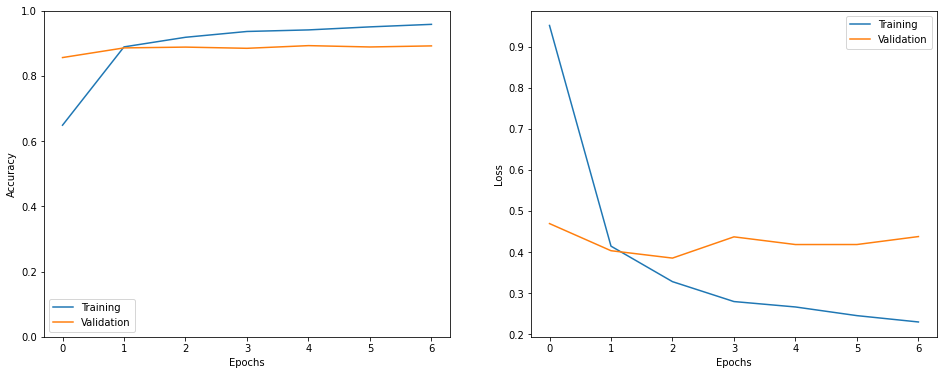

In [27]:
show_history(h)

In [28]:
test_text, test_labels = get_text(test)
test_seq = get_sequences(tokenizer, test_text)
test_labels = names_to_ids(test_labels)

In [29]:
_=model.evaluate(test_seq, test_labels)

77/77 [==============================] - 0s 6ms/step - loss: 0.4748 - accuracy: 0.8709


In [30]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_text[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i am feeling very strange but this is also present movement and i am trying this as one of way
Emotion: fear
Predicted Emotion: fear


In [31]:
preds = np.argmax(model.predict(test_seq), axis=-1)

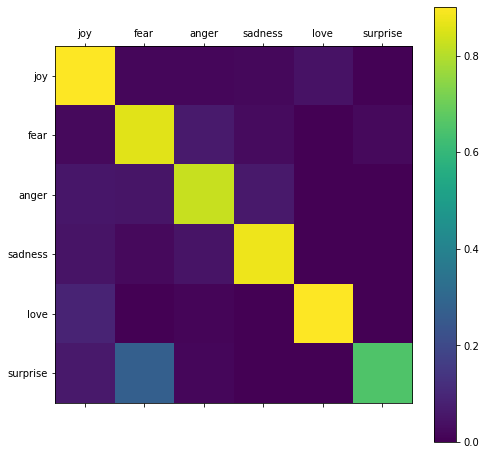

In [32]:
show_confusion_matrix(test_labels, preds, list(classes))

In [33]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       808
           1       0.81      0.86      0.83       326
           2       0.82      0.83      0.82       380
           3       0.93      0.88      0.90       694
           4       0.80      0.90      0.85       159
           5       0.78      0.65      0.71        66

    accuracy                           0.87      2433
   macro avg       0.84      0.84      0.84      2433
weighted avg       0.87      0.87      0.87      2433



In [34]:
from datetime import datetime
model.save("C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/Alternative Model/SA_Model_Alt_{}".format(datetime.now().strftime("%d%m%Y_%H_%M_%S")))

INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/Alternative Model/SA_Model_Alt_14022022_22_35_48\assets


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/Alternative Model/SA_Model_Alt_14022022_22_35_48\assets
